In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot_tools import plot_groups, plot_input_image
import h5py
import os
import os.path
%matplotlib inline
np.random.seed(9825619)

data_dir = os.environ.get('BRAINSTORM_DATA_DIR', '.')

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib-1.5.0+783.g23bc09d-py3.4-linux-x86_64.egg/matplotlib/__init__.py:877: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Load the MNIST Dataset as prepared by the brainstorm data script
# You will need to run brainstorm/data/create_mnist.py first
with h5py.File(os.path.join(data_dir, 'MNIST.hdf5'), 'r') as f:
    mnist_digits = f['normalized_full/training/default'][0, :]
    mnist_targets = f['normalized_full/training/targets'][:]
    mnist_digits_test = f['normalized_full/test/default'][0, :]
    mnist_targets_test = f['normalized_full/test/targets'][:]

# Multi MNIST

Binary images containing three thresholded MNIST digits. (Same thresholding as in [1]).

We chose the image size to be $48 \times 48 = 2304$ because that is roughly $28 \times 28 \times 3 = 2352$

In [3]:
def crop(d):
    return d[np.sum(d, 1) != 0][:, np.sum(d, 0) != 0]

In [4]:
def generate_multi_mnist_img(digit_nrs, size=(48, 48), test=False, binarize_threshold=0.5):
    if not test:
        digits = [crop(mnist_digits[nr].reshape(28, 28)) for nr in digit_nrs]
    else:
        digits = [crop(mnist_digits_test[nr].reshape(28, 28)) for nr in digit_nrs]
        
    img = np.zeros(size)
    grp = np.zeros(size)
    mask = np.zeros(size)
    k = 1
    
    for i, digit in enumerate(digits):
        h, w = size
        sy, sx = digit.shape
        x = np.random.randint(0, w-sx+1)
        y = np.random.randint(0, h-sy+1)
        region = (slice(y,y+sy), slice(x,x+sx))
        m = digit >= binarize_threshold
        img[region][m] = 1  
        mask[region][m] += 1  
        grp[region][m] = k      
        k += 1
        
    grp[mask > 1] = 0  # ignore overlap regions
    return img, grp
    

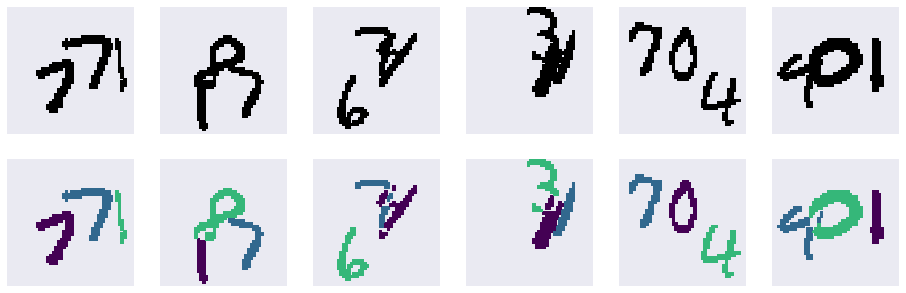

In [5]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(16, 5))
for ax in axes.T:
    digit_nrs = np.random.randint(0, 60000, 3)
    img, grp = generate_multi_mnist_img(digit_nrs)
    plot_input_image(img, ax[0])
    plot_groups(grp, ax[1])

## Save as HDF5

In [6]:
np.random.seed(36520)
nr_digits = 3
nr_training_examples = 60000
nr_test_examples = 10000
nr_single_examples = 60000
size = (48, 48)

data = np.zeros((1, 60000) + size + (1,), dtype=np.float32)
grps = np.zeros_like(data)
targets = np.zeros((1, 60000, nr_digits), dtype=np.int)
for i in range(60000):
    digit_nrs = np.random.randint(0, 60000, nr_digits)
    data[0, i, :, :, 0], grps[0, i, :, :, 0] = generate_multi_mnist_img(digit_nrs, size=size)
    targets[0, i, :] = mnist_targets[0, digit_nrs, 0]
    
data_test = np.zeros((1, 10000) + size + (1,), dtype=np.float32)
grps_test = np.zeros_like(data_test)
targets_test = np.zeros((1, 10000, nr_digits), dtype=np.int)
for i in range(10000):
    digit_nrs = np.random.randint(0, 10000, nr_digits)
    data_test[0, i, :, :, 0], grps_test[0, i, :, :, 0] = generate_multi_mnist_img(digit_nrs, size=size, test=True)
    targets_test[0, i, :] = mnist_targets_test[0, digit_nrs, 0]
    
data_single = np.zeros((1, nr_single_examples) + size + (1,), dtype=np.float32)
grps_single = np.zeros_like(data_single )
targets_single = np.zeros((1, nr_single_examples, 1), dtype=np.int)
for i in range(nr_single_examples):
    data_single [0, i, :, :, 0], grps_single[0, i, :, :, 0] = generate_multi_mnist_img([i], size=size)
    targets_single[0, i, :] = mnist_targets[0, i, 0]

In [7]:
with h5py.File(os.path.join(data_dir, 'multi_mnist.h5'), 'w') as f:
    single = f.create_group('train_single')
    single.create_dataset('default', data=data_single, compression='gzip', chunks=(1, 100) + size + (1,))
    single.create_dataset('groups', data=grps_single, compression='gzip', chunks=(1, 100) + size + (1,))
    single.create_dataset('targets', data=targets_single, compression='gzip', chunks=(1, 100, 1))
    
    train = f.create_group('train_multi')
    train.create_dataset('default', data=data, compression='gzip', chunks=(1, 100) + size + (1,))
    train.create_dataset('groups', data=grps, compression='gzip', chunks=(1, 100) + size + (1,))
    train.create_dataset('targets', data=targets, compression='gzip', chunks=(1, 100, nr_digits))
    
    test = f.create_group('test')
    test.create_dataset('default', data=data_test, compression='gzip', chunks=(1, 100) + size + (1,))
    test.create_dataset('groups', data=grps_test, compression='gzip', chunks=(1, 100) + size + (1,))
    test.create_dataset('targets', data=targets_test, compression='gzip', chunks=(1, 100, nr_digits))

# References

[1] Bishop, Christopher M. (2006) "Pattern Recognition and Machine Learning (Information Science and Statistics)"
Springer-Verlag New York, Inc., Secaucus, NJ, USA.
Section 9.3.3 p. 447